Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
seattle_calendar = pd.read_csv('//GBMLVFILFS01N02.rbsres01.net/home8$/Evanrdo/Personal/DS Nanodegree/seattle_calendar.csv')
seattle_listings = pd.read_csv('//GBMLVFILFS01N02.rbsres01.net/home8$/Evanrdo/Personal/DS Nanodegree/seattle_listings.csv')
seattle_reviews = pd.read_csv('//GBMLVFILFS01N02.rbsres01.net/home8$/Evanrdo/Personal/DS Nanodegree/seattle_reviews.csv')
boston_calendar = pd.read_csv('//GBMLVFILFS01N02.rbsres01.net/home8$/Evanrdo/Personal/DS Nanodegree/boston_calendar.csv')
boston_listings = pd.read_csv('//GBMLVFILFS01N02.rbsres01.net/home8$/Evanrdo/Personal/DS Nanodegree/boston_listings.csv')
boston_reviews = pd.read_csv('//GBMLVFILFS01N02.rbsres01.net/home8$/Evanrdo/Personal/DS Nanodegree/boston_reviews.csv')

Data Understanding and Data Cleaning

In [3]:
display(seattle_listings.head(1))

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [4]:
display(len(seattle_listings['id'].unique().tolist()))
display(len(boston_listings['id'].unique().tolist()))

3818

3585

In [5]:
display(seattle_listings.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [6]:
display(seattle_calendar.head(1))

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00


In [7]:
display(seattle_calendar['available'].isna().mean())
display(seattle_calendar['price'].isna().mean())
display(boston_calendar['available'].isna().mean())
display(boston_calendar['price'].isna().mean())

0.0

0.32938998399793334

0.0

0.5087157820748879

In [8]:
display(seattle_reviews.head(1))

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...


The amount of AirBnBs are roughly the same for both Seattle and Boston and therefore the dataframes can be directly compared. We must also be aware that there's a lot of missing price values in the calendar dataframe, however it may not be best to remove the null rows for every analysis.

Question 1 - Cost of AirBnbs

In [9]:
seattle_calendar_price = seattle_calendar.dropna(subset= ["price"])
boston_calendar_price = boston_calendar.dropna(subset= ["price"])

In [10]:
seattle_calendar_price["price"] = seattle_calendar_price["price"].str.replace('$', '')
seattle_calendar_price["price"] = pd.to_numeric(seattle_calendar_price["price"], errors='coerce')
display(seattle_calendar_price['price'].mean())

C:\Users\evanrdo\AppData\Local\Temp\ipykernel_1948\152802929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seattle_calendar_price["price"] = seattle_calendar_price["price"].str.replace('$', '')
C:\Users\evanrdo\AppData\Local\Temp\ipykernel_1948\152802929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seattle_calendar_price["price"] = pd.to_numeric(seattle_calendar_price["price"], errors='coerce')


137.19222676140043

In [11]:
boston_calendar_price["price"] = boston_calendar_price["price"].str.replace('$', '')
boston_calendar_price["price"] = pd.to_numeric(boston_calendar_price["price"], errors='coerce')
display(boston_calendar_price['price'].mean())

C:\Users\evanrdo\AppData\Local\Temp\ipykernel_1948\867018691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_calendar_price["price"] = boston_calendar_price["price"].str.replace('$', '')
C:\Users\evanrdo\AppData\Local\Temp\ipykernel_1948\867018691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_calendar_price["price"] = pd.to_numeric(boston_calendar_price["price"], errors='coerce')


192.45390955690283

We can see that the average cost of an AirBnb listing in Boston is more expensive than in Seattle.

Question 2 - Peak Times

In [12]:
seattle_calendar["price"] = seattle_calendar["price"].str.replace('$', '')
seattle_calendar["price"] = pd.to_numeric(seattle_calendar["price"], errors='coerce')

In [13]:
boston_calendar["price"] = boston_calendar["price"].str.replace('$', '')
boston_calendar["price"] = pd.to_numeric(boston_calendar["price"], errors='coerce')

In [14]:
def booked(row):
   if row['available'] == 't':
      return 1
   if row['available'] != 't':
      return 0

<Axes: xlabel='date'>

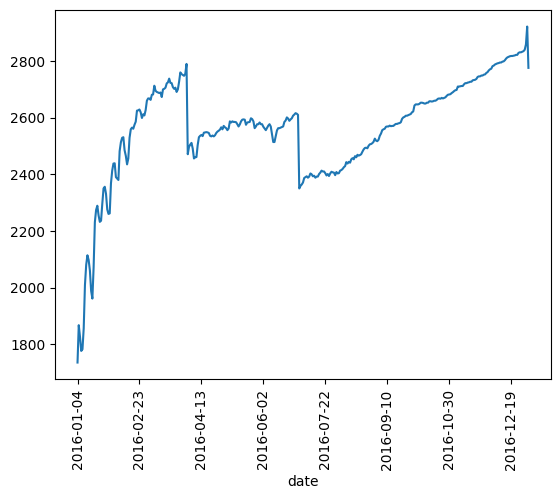

In [15]:
seattle_calendar['booked'] = seattle_calendar.apply(booked, axis=1)
popularity_by_date_seattle = seattle_calendar.groupby('date')['booked'].sum()
popularity_by_date_seattle.plot.line(rot=90)

<Axes: xlabel='date'>

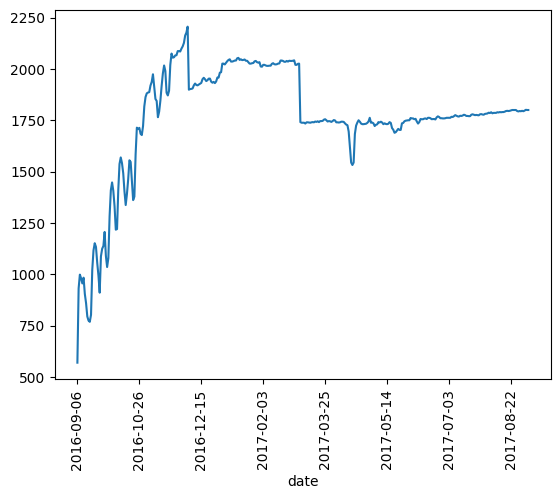

In [18]:
boston_calendar['booked'] = boston_calendar.apply(booked, axis=1)
popularity_by_date_boston = boston_calendar.groupby('date')['booked'].sum()
popularity_by_date_boston.plot.line(rot=90)

In [16]:
display(popularity_by_date_seattle.sort_values(ascending=False).head(1))
display(popularity_by_date_seattle.sort_values(ascending=True).head(1))

date
2017-01-01    2922
Name: booked, dtype: int64

date
2016-01-04    1735
Name: booked, dtype: int64

In [30]:
seattle_max_book = seattle_calendar[seattle_calendar['date'] == '2017-01-01']
seattle_min_book = seattle_calendar[seattle_calendar['date'] == '2016-01-04']

In [19]:
display(popularity_by_date_boston.sort_values(ascending=False).head(1))
display(popularity_by_date_boston.sort_values(ascending=True).head(1))

date
2016-12-04    2207
Name: booked, dtype: int64

date
2016-09-06    570
Name: booked, dtype: int64

In [31]:
boston_max_book = boston_calendar[boston_calendar['date'] == '2016-12-04']
boston_min_book = boston_calendar[boston_calendar['date'] == '2016-09-06']

In [29]:
display(seattle_calendar['price'].mean())
display(seattle_max_book['price'].mean())
display(seattle_min_book['price'].mean())
display(boston_calendar['price'].mean())
display(boston_max_book['price'].mean())
display(boston_min_book['price'].mean())

137.19222676140043

137.53664383561645

122.08587896253603

192.45390955690283

179.81326669695594

239.71001757469244

The peak booked times in both cities slightly varies, although both in December. Interestingly though, during the peak booked times in Boston, the average price of a listing is cheaper than the yearly average by around 10%. 

Question 3 - Value for money

In [21]:
seattle_listings["price"] = seattle_listings["price"].str.replace('$', '')
seattle_listings["price"] = pd.to_numeric(seattle_listings["price"], errors='coerce')
seattle_listings["price_per_person"] = seattle_listings["price"] / seattle_listings["accommodates"]
seattle_listings["cleaning_fee"] = seattle_listings["cleaning_fee"].str.replace('$', '')
seattle_listings["cleaning_fee"] = pd.to_numeric(seattle_listings["cleaning_fee"], errors='coerce')
seattle_listings["cleaning_per_person"] = seattle_listings["cleaning_fee"] / seattle_listings["accommodates"]
seattle_listings["security_deposit"] = seattle_listings["security_deposit"].str.replace('$', '')
seattle_listings["security_deposit"] = pd.to_numeric(seattle_listings["security_deposit"], errors='coerce')
seattle_listings["security_per_person"] = seattle_listings["security_deposit"] / seattle_listings["accommodates"]
seattle_listings['cost_per_person'] = seattle_listings["price_per_person"] + seattle_listings['cleaning_per_person'] + seattle_listings['security_per_person']

In [22]:
boston_listings["price"] = boston_listings["price"].str.replace('$', '')
boston_listings["price"] = pd.to_numeric(boston_listings["price"], errors='coerce')
boston_listings["price_per_person"] = boston_listings["price"] / seattle_listings["accommodates"]
boston_listings["cleaning_fee"] = boston_listings["cleaning_fee"].str.replace('$', '')
boston_listings["cleaning_fee"] = pd.to_numeric(boston_listings["cleaning_fee"], errors='coerce')
boston_listings["cleaning_per_person"] = boston_listings["cleaning_fee"] / boston_listings["accommodates"]
boston_listings["security_deposit"] = boston_listings["security_deposit"].str.replace('$', '')
boston_listings["security_deposit"] = pd.to_numeric(boston_listings["security_deposit"], errors='coerce')
boston_listings["security_per_person"] = boston_listings["security_deposit"] / boston_listings["accommodates"]
boston_listings['cost_per_person'] = boston_listings["price_per_person"] + boston_listings['cleaning_per_person'] + boston_listings['security_per_person']

In [23]:
display(seattle_listings['cost_per_person'].mean())
display(boston_listings['cost_per_person'].mean())

146.8128295607145

198.53066925092787

In [24]:
def value_for_money_seattle(row):
   if (row['cost_per_person'] <= 146.8128295607145) & (row['review_scores_rating'] >= 90):
      return 1
   else:
      return 0

In [25]:
seattle_listings['value_for_money'] = seattle_listings.apply(value_for_money_seattle, axis=1)
display((seattle_listings['value_for_money'].sum())/(seattle_listings.shape[0]/2) * 100)

40.963855421686745

In [26]:
def value_for_money_boston(row):
   if (row['cost_per_person'] <= 198.53066925092787) & (row['review_scores_rating'] >= 90):
      return 1
   else:
      return 0

In [27]:
boston_listings['value_for_money'] = boston_listings.apply(value_for_money_boston, axis=1)
display((boston_listings['value_for_money'].sum())/(boston_listings.shape[0]/2) * 100)

23.87726638772664

We see that the overall cost per person, which includes the cleaning and deposit fee, is cheaper in Seattle compared to Boston - as expected. Importantly though, you're also more likely to get better value for money in Seattle as a 41% of listings under the average cost per person value still have a review score of over 90, as oppose to only 24% in Boston. Therefore, it would be harder to find a 'budget' option in Boston which gives good value for money. 

Question 4 - Reviews about location.

In [66]:
display(len(seattle_reviews['listing_id'].unique().tolist()))
seattle_listings_df = seattle_listings[seattle_listings['review_scores_rating'] >= 90]
seattle_listings_list = seattle_listings_df['id'].unique().tolist()
seattle_reviews_df = seattle_reviews[seattle_reviews['listing_id'].isin(seattle_listings_list)]
display(len(seattle_reviews_df['listing_id'].unique().tolist()))

3191

2745

In [62]:
seattle_comments = seattle_reviews_df[seattle_reviews_df['comments'].str.contains('location', na=False)]
display(len(seattle_comments['listing_id'].unique().tolist()))
display((len(seattle_comments['listing_id'].unique().tolist()))/(len(seattle_reviews_df['listing_id'].unique().tolist())) * 100)

2345

85.42805100182149

In [59]:
display(len(boston_reviews['listing_id'].unique().tolist()))
boston_listings_df = boston_listings[boston_listings['review_scores_rating'] >= 90]
boston_listings_list = boston_listings_df['id'].unique().tolist()
boston_reviews_df = boston_reviews[boston_reviews['listing_id'].isin(boston_listings_list)]
display(len(boston_reviews_df['listing_id'].unique().tolist()))

2829

2052

In [63]:
boston_comments = boston_reviews_df[boston_reviews_df['comments'].str.contains('location', na=False)]
display(len(boston_comments['listing_id'].unique().tolist()))
display((len(boston_comments['listing_id'].unique().tolist()))/(len(boston_reviews_df['listing_id'].unique().tolist())) * 100)

1644

80.11695906432749

Of the listings which recieve a review score of higher than 90 and filtering the comments for the key word 'location', this shows the listings where location plays a role in determining the high review score. Of course those doesn't mean that the comment regarding 'location' has to be positive, however it is likely and this is beneficial when planning a trip. As we can see, the percentage of listings is higher for Seattle compared to Boston.